In [48]:
import copy
import numpy as np
from PIL import  Image
from typing import Tuple, Literal
from matplotlib import  pyplot as plt

import torch
from torchvision.transforms.functional import rotate

import rospy
from nav_msgs.msg import OccupancyGrid
from std_msgs.msg import Float32MultiArray, MultiArrayDimension
from visualization_msgs.msg import Marker


def load_rosbag(file_path :str)-> OccupancyGrid:
    import rosbag
    bag = rosbag.Bag(file_path)
    for topic, msg, t in bag.read_messages():
        msg: OccupancyGrid = msg
        return msg
    
def occupancy2img(msg : OccupancyGrid) -> np.ndarray:
    '''
    преобразует OccupancyGrid в np.ndarray с нормализацией
    '''
    occ = np.array(msg.data, dtype=np.float)
    occ = occ.reshape((msg.info.height, msg.info.width))
    occ /= occ.max()
    occ[::-1, :] = occ
    return occ

def plot_map(occ_img : np.array, fig_size : Literal['big', 'medium' , 'small'] = 'medium', title : str = None):
    '''
    figsize:
    (15, 10) - big
    (10, 5) - medium
    (5, 3) - small
    '''
    choose = {
        'big' : (15, 10),
        'medium' : (10, 5),
        'small' : (5,3)
    }[fig_size]
    plt.figure(figsize=choose)
    plt.imshow(occ_img)
    if title is not None:
        plt.title(title)
    plt.colorbar()
    plt.show()

def point2pixelOCC(msg : OccupancyGrid, point : Tuple[float, float, float]) -> Tuple[int, int]:
    '''
    реальные координаты в пиксель на occupancy grid с учетом разрешения
    '''
    iy = round((point[0] - msg.info.origin.position.x)/msg.info.resolution)
    ix = round((point[1] - msg.info.origin.position.y)/msg.info.resolution)
    return (int(ix), int(iy))

def pixel2pointOCC(msg : OccupancyGrid, pixel : Tuple[int, int]) -> Tuple[float, float, float]:
    '''
    координаты в пикселях в реальные координаты с учетом разрешения occupancy grid
    '''
    x = msg.info.origin.position.x + pixel[1]*msg.info.resolution
    y = msg.info.origin.position.y + (msg.info.height-1 - pixel[0])*msg.info.resolution
    z = msg.info.origin.position.z
    return (x, y, z)

def load_fooptint(file_path) -> torch.Tensor:
    '''
    Загружает из фала футпринт:
        1. преобразует в одноцветный 
        2. нормализует 
        3. инвертирует 
        4. выделяет только область достижимости (она имеет значения 1, фон - 0, область достижимости манипулятора - 0.5)
        5. генерирует 15 поворотов от 0 до 360
    '''
    i = Image.open(file_path)
    np_img = np.asarray(i)
    np_img = np.int32(np.linalg.norm(np_img[:,:, :3], axis=-1))
    np_img = np_img / np_img.max() # нормализация по максимуму
    np_img = 1 - np_img # инверсия цветов
    np_img = (np_img == np_img.max()).astype(np.float)
    rotated_img = [rotate(img = torch.tensor(np_img).unsqueeze(0), angle=angl, fill =np_img.min()  ).squeeze(0) for angl in np.linspace(0, 360, 4*4)][:-1]
    rotated_img = torch.stack(rotated_img)
    return rotated_img

def load_manipulator_footprint(file_path):
    '''
    Загружает из фала область достижимости манипулятора:
        1. преобразует в одноцветный 
        2. нормализует 
        3. инвертирует 
        4. выделяет только область достижимости (она имеет значения 0.5, фон - 0, футпринт базы -1)
        5. генерирует 15 поворотов от 0 до 360
    '''
    i = Image.open(file_path)
    np_img = np.asarray(i)
    np_img = np.int32(np.linalg.norm(np_img[:,:, :3], axis=-1))
    np_img = np_img / np_img.max() # нормализация по максимуму
    np_img = 1 - np_img # инверсия цветов
    np_img = ((np_img < 1) & (np_img > 0)).astype(np.float)
    np_img[np_img!=0] -= 0.5 # понижаем интенсивность
    np_img[0:9, 7:12] = 1.0 # даем самые большие значения центральному прямоугольнику 
    rotated_img = [rotate(img = torch.tensor(np_img).unsqueeze(0), angle=angl, fill =np_img.min()  ).squeeze(0) for angl in np.linspace(0, 360, 4*4)][:-1]
    rotated_img = torch.stack(rotated_img)
    return rotated_img

def compute_convolve(img, footprint) -> torch.Tensor:
    '''
    img - передается карта занятости или distance map shape (y, x)
    footprint - футпринт робота shape (thata, a, b) или (a, b)
    
    returns:
        свертку футпринтов с изображением
    '''
    if not isinstance(img, torch.Tensor):
        img_tensor = torch.tensor(img, dtype=torch.float32, requires_grad=False)
    else:
        img_tensor = img.clone().detach()
        img_tensor = img_tensor.view(torch.float32)
    if not isinstance(footprint, torch.Tensor):
        footprint_tensor = torch.tensor(footprint, dtype=torch.float32, requires_grad=False)
    else:
        footprint_tensor = footprint.clone().detach()
        footprint_tensor = footprint_tensor.float()
    img_tensor = img_tensor.unsqueeze(axis = 0) # to shape (1, thata, a, b)
    if len(img_tensor.shape) == 2: 
        img_tensor = img_tensor.unsqueeze(axis=0)
    if len(footprint_tensor.shape) == 2: # на случай если для отладки нужно будет передать не куб изображений, а только один футпринт
        footprint_tensor = footprint_tensor.unsqueeze(axis=0)
    footprint_tensor = footprint_tensor.unsqueeze(axis=1)
    out = torch.nn.functional.conv2d(img_tensor, footprint_tensor, padding='same')
    return out

# для отправки задачи планировщику
class TaskPublisher:
    def __init__(self) -> None:
        rospy.init_node('planner_sender')
        self.task_publisher = rospy.Publisher('/task', Float32MultiArray, queue_size=1)
        self.occ_publisher = rospy.Publisher('/map', OccupancyGrid, queue_size=1)

    def pubPoint(self, x, y, topic):
        m = Marker()
        m.action = m.ADD
        m.type = m.CUBE
        m.color.a = 255
        m.color.r = 255
        m.scale.x = 0.2
        m.scale.y = 0.2
        m.scale.z = 0.2
        m.pose.position.x, m.pose.position.y, m.pose.position.z = x, y, 0
        m.header.frame_id = "local_map_lidar"
        m.pose.orientation.w = 1
        
        rospy.Publisher(topic, Marker, queue_size=1).publish(m)

    def publish_pathplanning_task(self, occ_grid : OccupancyGrid, start_x, start_y, goal_x, goal_y, goal_theta):
            task = Float32MultiArray()
            task.layout.data_offset = 0
            task.layout.dim.append(MultiArrayDimension())
            task.layout.dim[0].label = "width"
            if goal_theta is None:
                task.layout.dim[0].size  = 4
                task.layout.dim[0].stride  = 4
                task.data = [start_x, start_y, goal_x, goal_y]
            else:
                task.layout.dim[0].size  = 5
                task.layout.dim[0].stride  = 5
                task.data = [start_x, start_y, goal_x, goal_y, goal_theta]
            self.occ_publisher.publish(occ_grid)
            self.task_publisher.publish(task)
            self.occ_publisher.publish(occ_grid)
            self.pubPoint(start_x, start_y, '/start_point')
            self.pubPoint(goal_x, goal_y, '/goal_point')
            

## Загрузка данныйх

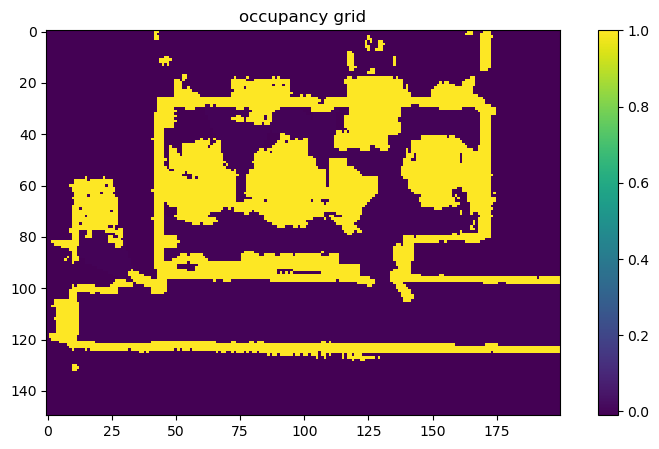

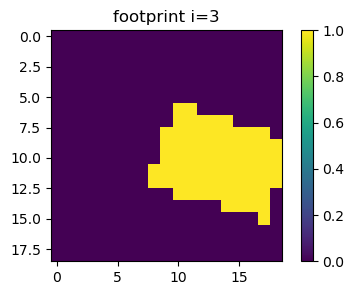

map_load_time: 
  secs: 0
  nsecs:         0
resolution: 0.10000000149011612
width: 1177
height: 341
origin: 
  position: 
    x: -20.30000114440918
    y: -25.399999618530273
    z: 0.0
  orientation: 
    x: 0.0
    y: 0.0
    z: 0.0
    w: 1.0


In [49]:
# вырежем небольшую область с которой удобнее работать чем со всей картой
crop_size = [
    [50, 200],
    [50, 250]
]  
crop = lambda x : x[crop_size[0][0] : crop_size[0][1], crop_size[1][0] : crop_size[1][1]]
croped2uncroped = lambda x: [x[0] + crop_size[0][0], x[1] + crop_size[1][0]]
uncroped2croped = lambda x : [x[0] - crop_size[0][0], x[1] - crop_size[1][0]]

occ_map = load_rosbag('ocupancy.bag')
occ_image = crop(occupancy2img(occ_map))
foot_prints = load_fooptint('realrobot_footprint.png')
plot_map(occ_image, 'medium', 'occupancy grid')
show_footprint_indx = 3
plot_map(foot_prints[show_footprint_indx], 'small', f'footprint i={show_footprint_indx}')
print(occ_map.info)

torch.Size([15, 150, 200])
tensor(71.)
1.0 tensor(1., dtype=torch.float64)


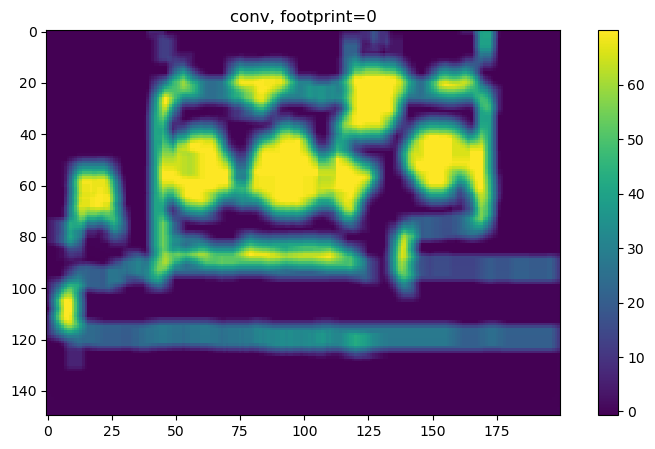

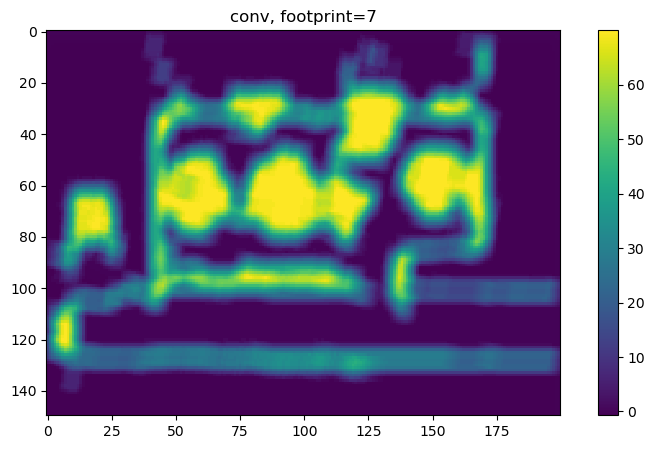

In [50]:
out = compute_convolve(occ_image, foot_prints)
print(out.shape)
print(out.max())
print(occ_image.max(), foot_prints.max())
plot_map(out[0], 'medium', 'conv, footprint=0')
plot_map(out[7], 'medium',  'conv, footprint=7')

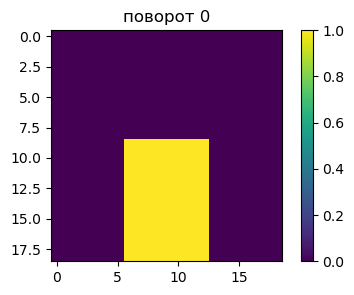

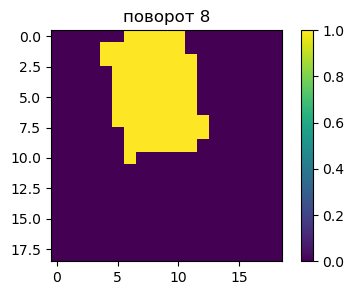

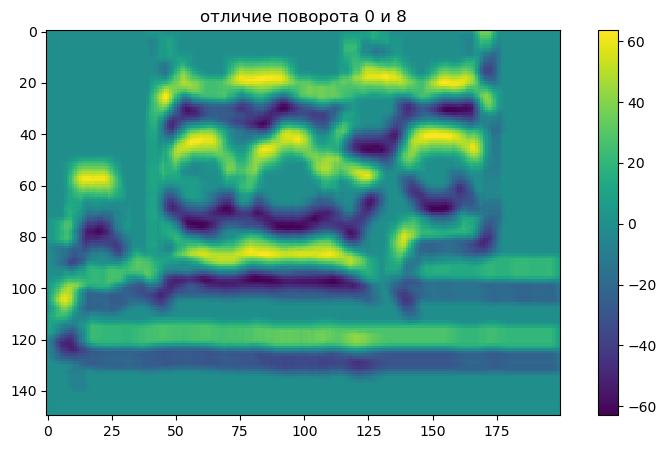

In [67]:
i1, i2 = 0, 8
plot_map(foot_prints[i1], 'small', f'поворот {i1}')
plot_map(foot_prints[i2], 'small', f'поворот {i2}')
plot_map(out[i1]-out[i2], title=f'отличие поворота {i1} и {i2}')

## Построение distance-field
- Каждая точка заполняется значением расстояния до цели
- Карта нормируется по максимальному значению и инвертируется
- Создается маска со свободными клетками, находящимися в пределах некоторого радиуса от цели 

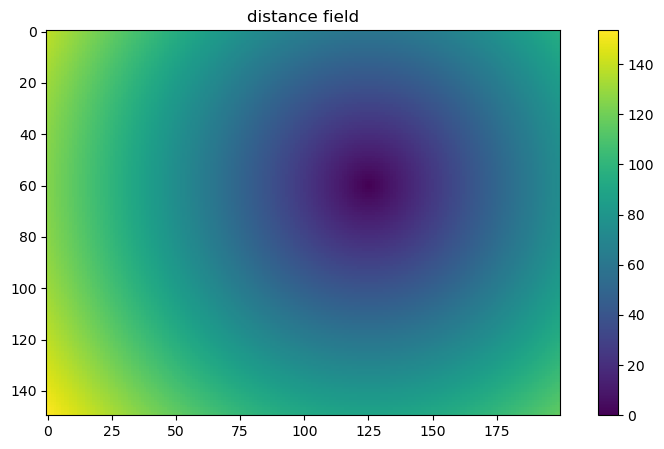

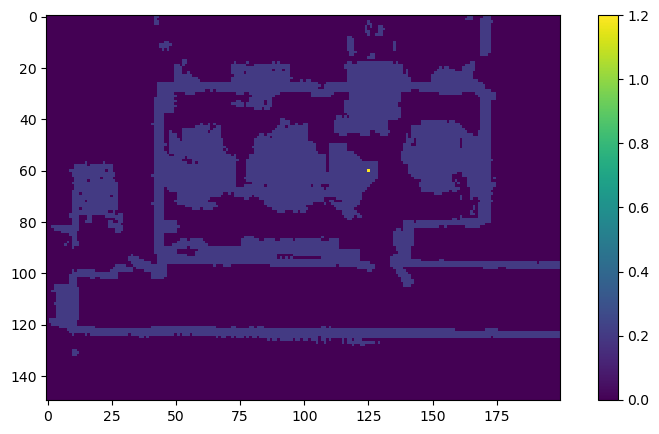

In [51]:
def make_dist_map(target : Tuple[int, int] , size : Tuple[int, int]):
    img = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            img[i, j] = np.linalg.norm([target[0] - i, target[1] - j])
    return  img
def norm_inv_hmap(hmap : np.ndarray):
    buf = copy.deepcopy(hmap)
    buf /= buf.max()
    return 1 - buf
target_pixels =  (60, 125)
dist_map = make_dist_map(target_pixels, occ_image.shape)
normed_inv_dist_map = norm_inv_hmap(dist_map)


plot_map(dist_map, 'medium', 'distance field')
plot_map((dist_map < 0.1/occ_map.info.resolution).astype(np.float)+occ_image*0.2, 'medium')

## Маскирование точек доступных для выбора алгоритмом

В некотором радиусе от цели выбираются все свободные точки

(154, 2)


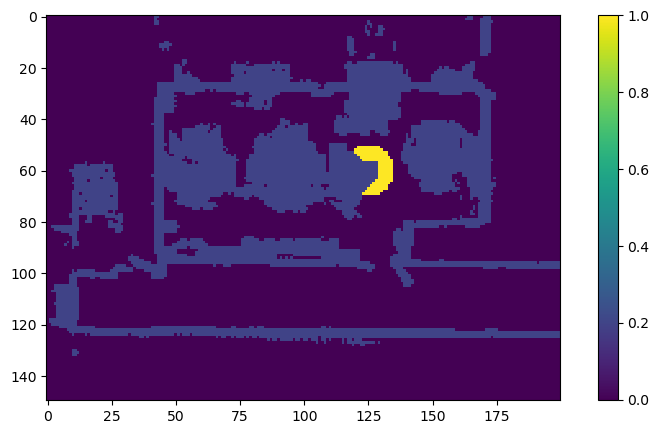

In [52]:
radius_max = 1
select_points_mask = dist_map < radius_max/occ_map.info.resolution
free_points_mask = occ_image < 0.1 
free_pixels = np.argwhere(select_points_mask & free_points_mask)
print(free_pixels.shape)
plot_map((select_points_mask & free_points_mask).astype(np.float) + 0.2*occ_image, 'medium')

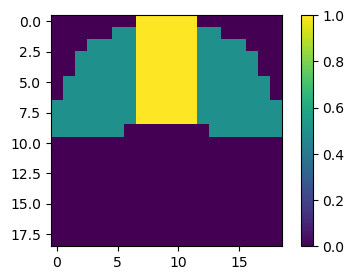

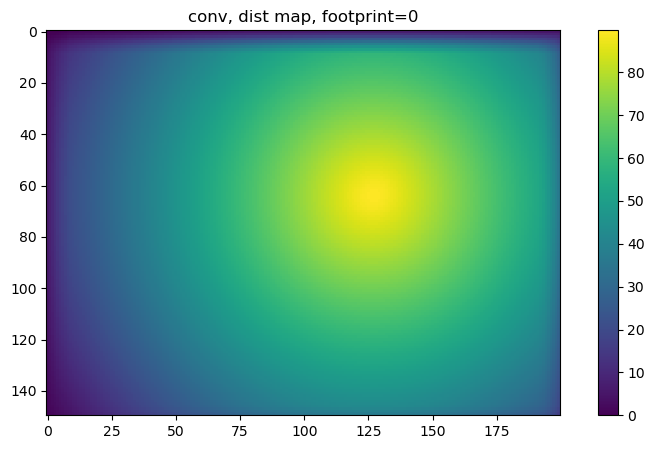

In [74]:
# manipulator_mask = ((foot_prints > 0) & (foot_prints <1)).type(torch.float32)
manipulator_mask = load_manipulator_footprint('realrobot_footprint.png')
# manipulator_mask = load_fooptint
dist_map_conv_foot = compute_convolve(normed_inv_dist_map, manipulator_mask)
# for i, b in enumerate(dist_map_conv_foot):
#     dist_map_conv_foot[i] /=  b.max()
plot_map(manipulator_mask[0], 'small')
plot_map(dist_map_conv_foot[1], title='conv, dist map, footprint=0')
# dist_map_conv_foot[:, np.logical_not(select_points_mask & free_points_mask)] = 0
# plot_map(dist_map_conv_foot[0], 'medium')
# print(dist_map_conv_foot[0][dist_map_conv_foot[0]!=0].min(), dist_map_conv_foot[0][dist_map_conv_foot[0]!=0].max())

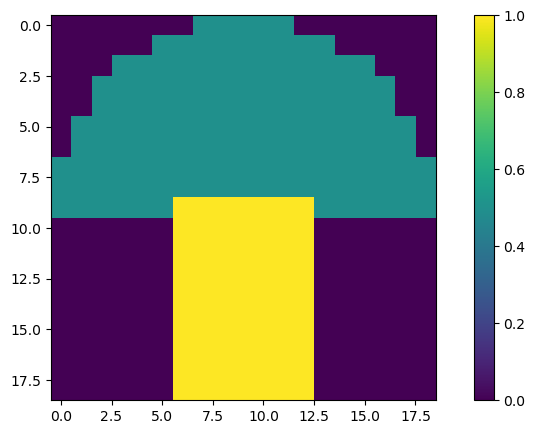

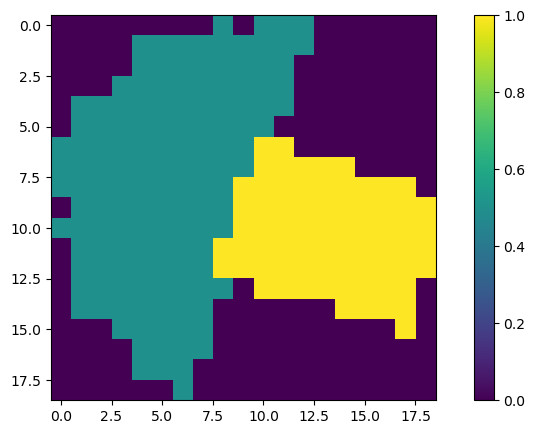

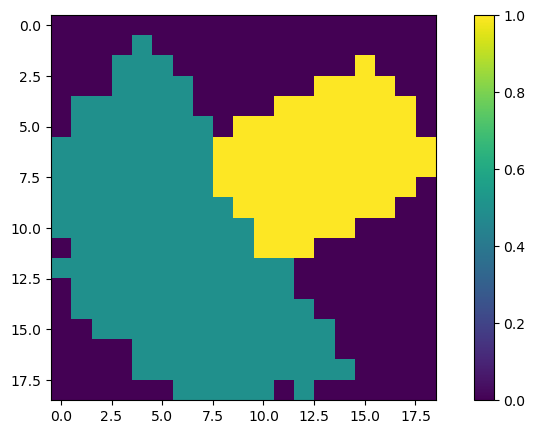

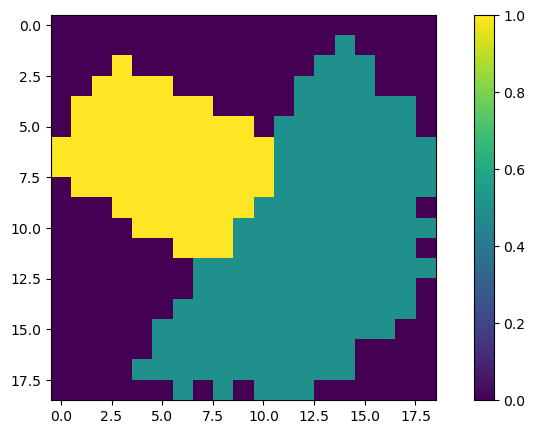

In [72]:
plot_map(foot_prints[0] + 0.5*(manipulator_mask[0] > 0))
plot_map(foot_prints[3] + 0.5*(manipulator_mask[3] > 0))
plot_map(foot_prints[5] + 0.5*(manipulator_mask[5] > 0))
plot_map(foot_prints[10] + 0.5*(manipulator_mask[10] > 0))

## Выбор цели для планирования

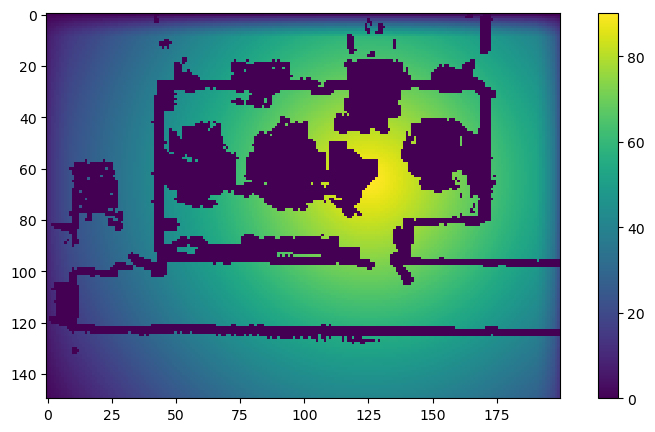

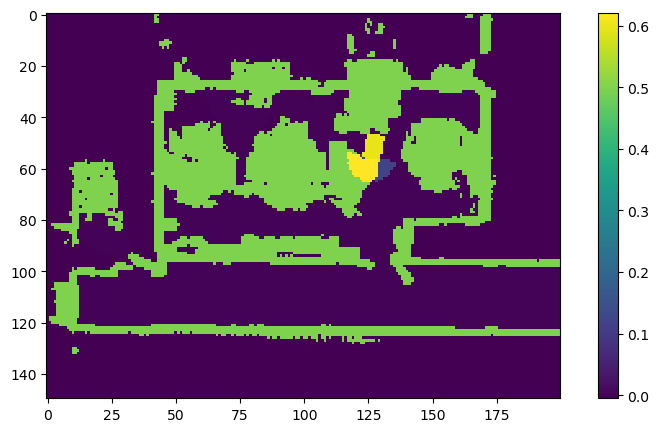

(56, 126, 7)


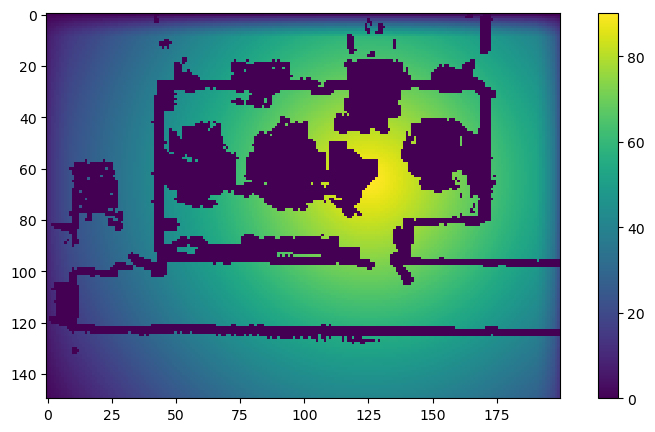

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.])
tensor([90.0989, 89.7519, 91.2043, 89.3109, 90.2588, 93.1417, 90.7514, 90.2731,
        90.2731, 90.7450, 91.8907, 89.4498, 87.8679, 90.0847, 89.2464])


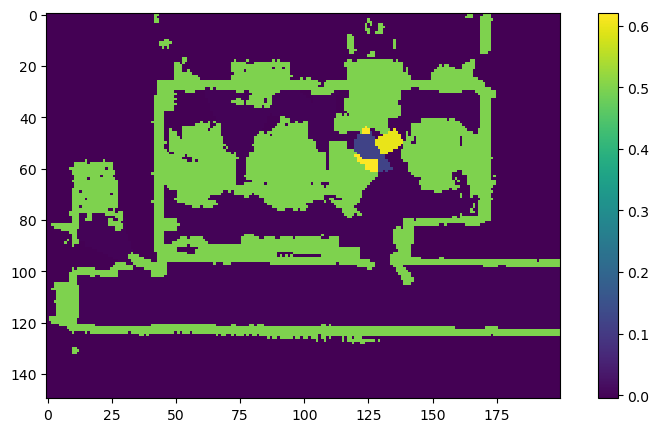

(52, 129, 5)


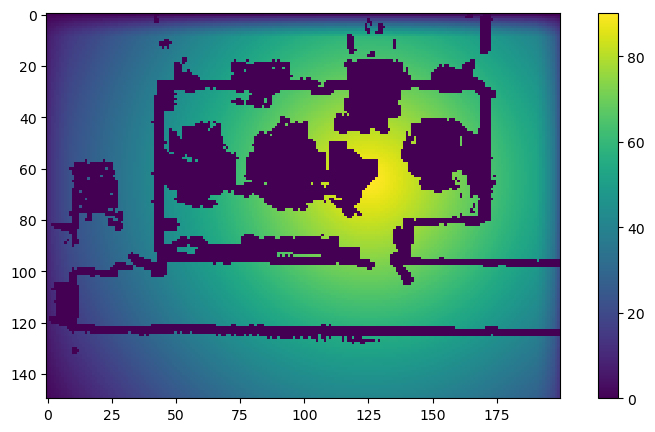

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0.0327, 0.0364, 0.0208, 0.0411, 0.0310, 0.0000, 0.0257, 0.0308, 0.0308,
        0.0257, 0.0134, 0.0396, 0.0566, 0.0328, 0.0418])


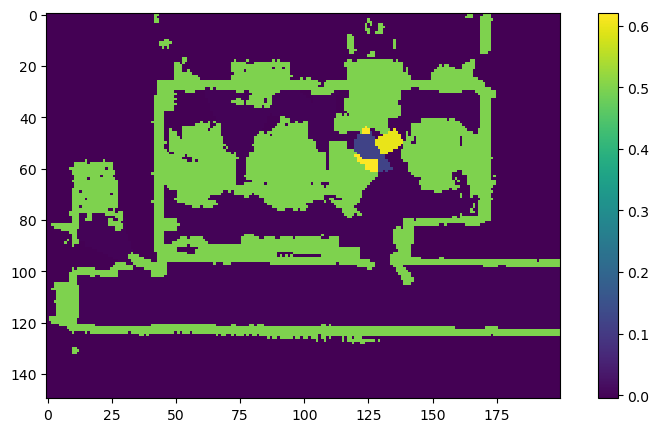

(52, 129, 5)


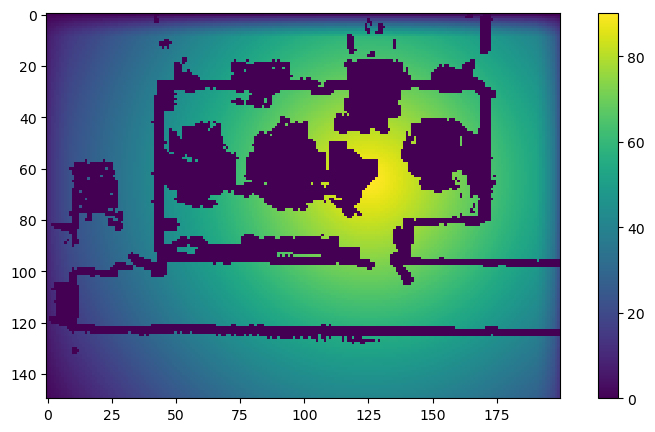

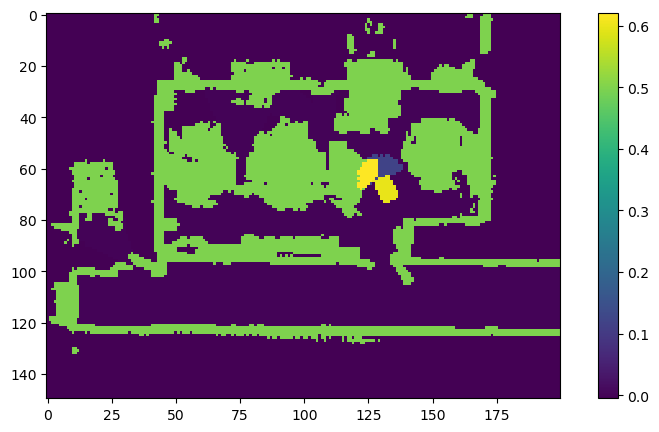

(64, 130, 1)


In [63]:
def get_sampler_mask(occ_grid : np.ndarray, dist_map : np.ndarray, resolution, max_r = 1)-> np.ndarray:
    select_points_mask = dist_map < max_r/resolution #маска на точки не дальше некоторого расстояния, True-  попадает в радиус
    free_points_mask = occ_grid < 0.1
    return select_points_mask , free_points_mask

def get_maximum_pixel_cords(grid : torch.Tensor) -> torch.Tensor:
    '''
    На вход принимает результат сверток, отдает по каналам координаты максимальных значений.
    (Суть для каждого варианта поворота отбирается по одной точке с максимальными значениями)
    '''
    n, a, b = grid.shape
    m = grid.view(n, -1).argmax(1).view(-1, 1)
    inds = torch.cat(( m//b, m%b), dim=1)
    return inds 

def get_minimum_pixel_cords(grid : torch.Tensor) -> torch.Tensor:
    '''
    Аналогично get_maximum_pixel_cords, но минимальные
    '''
    buf = copy.deepcopy(grid)
    if len(grid.shape) == 2:
        buf = grid.unsqueeze(0)
    n, a, b = buf.shape
    m = buf.view(n, -1).argmin(1).view(-1, 1)
    inds = torch.cat((m//b, m%b), dim=1)
    return inds 

def build_thetagrid(batched_images : torch.Tensor) -> torch.Tensor:
    '''
    Из результатов свертки конструируется изображение равное по разрешению occupancy grid, где в каждой клетке записан угол поворота с минимальными значениями
    '''
    b, ysize, xsize = batched_images.shape
    buf = torch.zeros((ysize, xsize))
    for i in range(ysize):
        for j in range(xsize):
            buf[i, j] = batched_images[:, i, j].argmin(0)
    return buf

def select_plan_task(
                     target_pixel           : Tuple[int, int], 
                     occ_grid               : np.ndarray, 
                     dist_map               : np.ndarray,
                     score_occ_grid         : torch.Tensor, 
                     score_dist_grid        : torch.Tensor, 
                     resolution             : float,
                     alg : Literal['a', 'b', 'c'] = 'a'
                    ) -> Tuple[int, int, int]:
    '''
    returns: (ypixel, xpixel, thetapixel)
    '''
    # plot_map(occ_grid)
    # print(score_dist_grid.shape)
    # plot_map(dist_map)
    # plot_map(score_occ_grid[2])
    # plot_map(score_dist_grid[3])
    select_points_mask, free_points_mask = get_sampler_mask(occ_grid, dist_map, resolution)
    sampler_mask = select_points_mask & free_points_mask
    free_score_occ_grid = copy.deepcopy(score_occ_grid)
    free_score_occ_grid[:, np.logical_not(sampler_mask)] = score_occ_grid.max()
    free_score_dist_grid = copy.deepcopy(score_dist_grid)
    free_score_dist_grid[:, np.logical_not(free_points_mask)] = score_dist_grid.min()
    plot_map(free_score_dist_grid[0])
    min_occ_pixel_cords = get_minimum_pixel_cords(free_score_occ_grid)
    max_dist_pixel_cords = get_maximum_pixel_cords(free_score_dist_grid)
    if alg == 'b':
        min_occ_scores = [free_score_occ_grid[i, v[0], v[1]].item() for i, v in enumerate(min_occ_pixel_cords)] 
        max_dist_scores = [free_score_dist_grid[i, v[0], v[1]].item() for i, v in enumerate(max_dist_pixel_cords)]
        min_occ_scores = torch.tensor(min_occ_scores)
        max_dist_scores = torch.tensor(max_dist_scores)
        theta = max_dist_scores.argmax()
        pos = min_occ_pixel_cords[theta]
        print(min_occ_scores)
        print(max_dist_scores)
        # print(max_dist_pixel_cords)
        # print(min_occ_pixel_cords)
    elif alg == 'a':
        v = max_dist_pixel_cords - min_occ_pixel_cords
        d = torch.sqrt( v[:, 0]**2 + v[:, 1]**2)
        theta = d.argmin()
        pos =min_occ_pixel_cords[theta]
    elif alg == 'c':
        min_occ_scores = [free_score_occ_grid[i, v[0], v[1]].item() for i, v in enumerate(min_occ_pixel_cords)] 
        max_dist_scores = [free_score_dist_grid[i, v[0], v[1]].item() for i, v in enumerate(max_dist_pixel_cords)]
        min_occ_scores = torch.tensor(min_occ_scores)
        max_dist_scores = torch.tensor(max_dist_scores)
        min_occ_scores /= min_occ_scores.max()
        max_dist_scores /= max_dist_scores.max()
        max_dist_scores = 1-  max_dist_scores
        print(min_occ_scores)
        print(max_dist_scores)
        theta = torch.sqrt((min_occ_scores**2 + max_dist_scores**2)).argmin()
        pos = min_occ_pixel_cords[theta]
    elif alg == 'thetamap':
        dist_theta_grid = build_thetagrid(free_score_dist_grid)
        occ_theta_grid = build_thetagrid(free_score_occ_grid)
        pos = torch.abs(dist_theta_grid - occ_theta_grid).argmin()
        
        pos = torch.stack([pos // dist_theta_grid.shape[-1], pos % dist_theta_grid.shape[-1]])
        theta = dist_theta_grid[pos[0], pos[1]]
        print(theta)
        print(pos)
    elif alg == 'random':
        it = 0
        trashhold_occ = 1
        trashhold_dist = 80
        while it < 1000:
            theta_max, _, _ = free_score_occ_grid.shape
            theta_max-= 1
            theta = np.random.randint(0, theta_max) 
            free_cords = np.argwhere(sampler_mask)
            pos = np.random.choice(range(0, free_cords.shape[0]))
            pos = free_cords[pos]
            score_dist = free_score_dist_grid[theta, pos[0], pos[1]]
            score_occ = free_score_occ_grid[theta, pos[0], pos[1]]
            if score_dist > trashhold_dist and score_occ < trashhold_occ:
                pos = torch.tensor(pos)
                theta = torch.tensor(theta)
                break
            it += 1

    else:
        raise NotImplementedError
        
    # print(d.argmin())
    # print(min_pixel_cords[d.argmin()])
    return (int(pos[0].item()), int(pos[1].item()), int(theta.item()))
for alg in ['a', 'b', 'c', 'random']:
    final_cord = select_plan_task(target_pixels, occ_image, dist_map, out, dist_map_conv_foot, occ_map.info.resolution, alg)

    half_size = foot_prints[0].shape[0]//2
    vis_img = np.zeros_like(occ_image)
    vis_img += 0.5 * occ_image
    vis_img[final_cord[0]-half_size: final_cord[0] + half_size + 1, final_cord[1] - half_size : final_cord[1] + half_size + 1] += (0.6* (foot_prints[final_cord[2]] + 0.2*(manipulator_mask[final_cord[2]] > 0)) ).tolist()
    plot_map(vis_img)
    print(final_cord)



## Send test task to planner

map_load_time: 
  secs: 0
  nsecs:         0
resolution: 0.10000000149011612
width: 1177
height: 341
origin: 
  position: 
    x: -20.30000114440918
    y: -25.399999618530273
    z: 0.0
  orientation: 
    x: 0.0
    y: 0.0
    z: 0.0
    w: 1.0


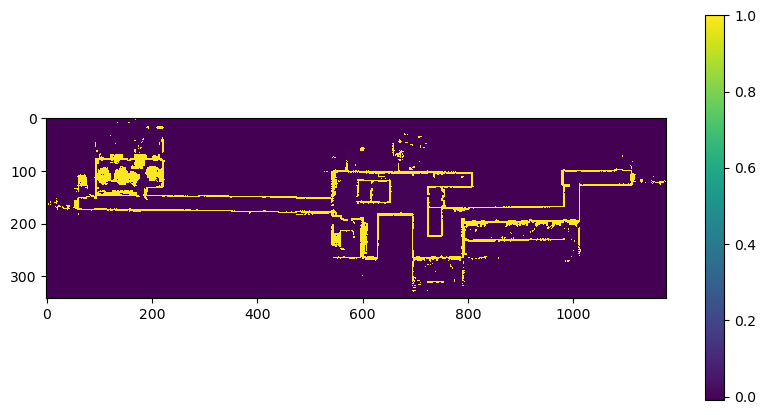

[160, 75]
[130, 1150]
(-12.80000103265047, -7.399999350309372, 0.0)
(-3.3000008910894394, -4.399999305605888, 0.0)


In [55]:
theta_pub = TaskPublisher()
print(occ_map.info)
all_occ_map = occupancy2img(occ_map)
plot_map(all_occ_map, 'medium')
p1 = pixel2pointOCC(occ_map, croped2uncroped((110, 25)))
p2 = pixel2pointOCC(occ_map, croped2uncroped((80, 120)))
print(croped2uncroped((110, 25)))
print(croped2uncroped((80, 1100)))
print(p1)
print(p2)
# theta_pub.publish_pathplanning_task(occ_map, *p1[:2], *p2[:2], 0)
theta_pub.publish_pathplanning_task(occ_map, *p2[:2], *p1[:2], None)